# Evaluate evoked LFP response by optogenetic stimulations

### Import recordings

Load packages

In [1]:
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import os
from IPython.display import display
from ipyfilechooser import FileChooser
from scipy.stats import zscore
import json
import matplotlib.cm as cm
import IPython
import ast

%matplotlib widget

In [2]:
#Load LFP coordinates 
notebook_path = Path("/".join(IPython.extract_module_locals()[1]["__vsc_ipynb_file__"].split("/")[-5:]))
Channels = f'{notebook_path.parent}/_LFP_coordinates_of_all_mice.csv'
all_LFPcoordinates = pd.read_csv(Channels, index_col=0)

Choose OpenEphys folder

In [3]:
try: # tries to retrieve dpath either from a previous run or from a previous notebook
    %store -r dpath
except:
    print("the path was not defined in store")
    dpath = "//10.69.168.1/crnldata/forgetting/"

fc1 = FileChooser(dpath,select_default=True, show_only_dirs = True, title = "<b>Go inside the folder containing the LFP raw file</b>")
display(fc1)

# Sample callback function
def update_my_folder(chooser):
    global dpath
    dpath = chooser.selected
    %store dpath
    return 

# Register callback function
fc1.register_callback(update_my_folder)

FileChooser(path='\\10.69.168.1\crnldata\forgetting\Carla\OpenEphysData\Sleep\3 mois\RondRouge_RondOrange_Rond…

Load LFPs data, TTL, timestamps

In [25]:
folder_base = Path(dpath) 
miceIDflipped=[]

if Path(f'{folder_base}\DataFrame_rawdataDS.pkl').exists(): # prefer loading downsample file over original file
    print('DataFrame_rawdataDS.pkl file')
    LFPfile = Path(f'{folder_base}\DataFrame_rawdataDS.pkl')
    LFPs_df = pd.read_pickle(LFPfile)
    samplerate = 1000 
    numchannel = LFPs_df.shape[1]
    rec_ch_list = LFPs_df.columns.values
    # Load LFPs timestamps 
    for file_pathTS in folder_base.parent.parent.glob('**/continuous/*/timeStampsDS.npy'):
        print('LFPs timestamps file found')
        LFPtimestamps = np.load(file_pathTS)  
elif Path(f'{folder_base}\continuous.dat').exists():
    print('continuous.dat file')
    LFPfile = Path(f'{folder_base}\continuous.dat')
    DataRec = np.fromfile(LFPfile, dtype="int16")
    filepath = Path(os.path.join(folder_base.parent.parent, f'structure.oebin'))
    with open(filepath) as f:
        metadata = json.load(f)
    samplerate = metadata['continuous'][0]['sample_rate']  
    numchannel = metadata['continuous'][0]['num_channels'] 
    rec_ch_list = np.array([int(''.join(c for c in metadata['continuous'][0]['channels'][x]['channel_name'] if c.isdigit()))-1 for x in range(0, len(metadata['continuous'][0]['channels']))])
    DataRec = DataRec.reshape(-1,numchannel)
    print('Metadata found')
    # Load LFPs timestamps 
    for file_pathTS in folder_base.parent.parent.glob('**/continuous/*/timeStamps.npy'):
        print('LFPs timestamps file found')
        LFPtimestamps = np.load(file_pathTS) 
    LFPs_df=pd.DataFrame(DataRec, columns=rec_ch_list) 
else: 
    print('no LFPs file found')

print('sample rate =', samplerate, 'Hz')
print(numchannel, 'channels recorded')
print(round(LFPs_df.shape[0]/samplerate/60), 'min of recording')

continuous.dat file
Metadata found
LFPs timestamps file found
sample rate = 10000.0 Hz
32 channels recorded
11 min of recording


In [26]:
nb_decimal=4 # 4 = 0.1ms precision / 3 = 1ms precision

# Load TTLs
TTL_Opto_duration=[]
for file_pathTTL in folder_base.parent.parent.glob('**/TTL/timeStamps.npy'):
    print('TTL opto file = ', file_pathTTL)
    TTL_Opto_o = np.load(file_pathTTL)
    TTL_Opto_duration =[round(TTL_Opto_o[i+1] - TTL_Opto_o[i],nb_decimal) for i in range(len(TTL_Opto_o) - 1)[::2]]
    TTL_Opto= TTL_Opto_o[::2] # remove the TTL for laser OFF, only keep TTL for laser ON. CAUTION /!/ works only if it started with a TTL for laser ON
    print(TTL_Opto.shape[0], 'opto stimulations')

TTL opto file =  \\10.69.168.1\crnldata\forgetting\Carla\OpenEphysData\Opto_stim\RondVert\RondVert_2025-06-30_10-58-14_StimOpto_04ms_6Mois_\Record Node 107\experiment1\recording1\events\OE_FPGA_Acquisition_Board-106.Rhythm Data\TTL\timeStamps.npy
110 opto stimulations


Downsample LFP data to 1kHz if needed & save it

In [27]:
if samplerate > 1000:
    new_sampling_rate = 1000 # Hz
    Nmber_points = int(np.shape(LFPs_df)[0] * new_sampling_rate / samplerate)
    LFPs_df_DS = pd.DataFrame(signal.resample(LFPs_df, Nmber_points, axis = 0), columns=LFPs_df.columns.values)
    LFPtimestampsDS = LFPtimestamps[::int(samplerate/new_sampling_rate)][:-1]
    samplerate = new_sampling_rate
    LFPs_df_DS.to_pickle(f'{LFPfile.parent}/DataFrame_rawdataDS.pkl')
    np.save(f'{file_pathTS.parent}/timeStampsDS.npy', LFPtimestampsDS)
    LFPs_df = LFPs_df_DS
    LFPtimestamps = LFPtimestampsDS
# eventually delete original files to gain space

Identify LFP electrodes

In [18]:
mouse = []
pos_mice = []

# Trouver les noms de souris dans le chemin
for mouse_name in all_LFPcoordinates.index:
    if mouse_name in str(LFPfile):
        mouse.append(mouse_name)
        pos_mice.append(str(LFPfile).find(mouse_name)) 

# Trier les noms de souris selon leur ordre d'apparition dans le chemin
mouse = [x for _, x in sorted(zip(pos_mice, mouse))] 

# Identifier quelle souris a été enregistrée
if len(mouse) > 1:
    if max(rec_ch_list) <= 31:
        id = 0
        ID = 0
        print(f"/!\ Plusieurs noms de souris trouvés dans le chemin mais une seule enregistrée = {mouse}. Le n°{id+1} a été choisi automatiquement = {mouse[id]}.")
        mouse = mouse[id]
    else:
        ID = 1
        print(f"/!\ Plusieurs souris enregistrées = {mouse}. Le n°{ID+1} a été choisi automatiquement = {mouse[ID]}.")
        mouse = mouse[ID]
elif len(mouse) == 1:
    ID = 0
    mouse = mouse[ID]
else:
    ID = 0
    mouse = ''

# Initialiser les variables
all_LFPcoordinates = all_LFPcoordinates.astype(str)
for region in all_LFPcoordinates.loc[mouse].index:
    locals()[f'{region}_0'] = []
    locals()[f'{region}_1'] = []
    locals()[f'{region}_0ch'] = []
    locals()[f'{region}_1ch'] = []

RecordedArea = []
ChoosenChannels = []
combined_list = []

# Remplir les signaux par région et canal
if mouse:
    rec_ch_list_mouse = [ch for ch in rec_ch_list if 0 + (ID * 32) <= ch <= 31 + (ID * 32)]
    for rec_ch in rec_ch_list_mouse:
        for idx, LFPcoord_str in enumerate(all_LFPcoordinates.loc[mouse]):
            region = all_LFPcoordinates.loc[mouse].index[idx]
            if LFPcoord_str != 'nan' and region != 'EMG':
                LFPcoord = LFPcoord_str.split('+AF8-')[:2]
                num_ch = np.where(str(rec_ch - (ID * 32)) == np.array(LFPcoord))[0]
                if len(num_ch) > 0:
                    LFP = np.array(LFPs_df[rec_ch])
                    if len(locals()[f'{region}_0']) > 0:
                        locals()[f'{region}_1'] = LFP
                        locals()[f'{region}_1ch'] = rec_ch
                    else:
                        locals()[f'{region}_0'] = LFP
                        locals()[f'{region}_0ch'] = rec_ch
                    break

# Construction de combined avec truncation
min_len = None
for region in all_LFPcoordinates.loc[mouse].index:
    for n in range(2):
        LFP = locals()[f'{region}_{n}']
        LFP_ch = locals()[f'{region}_{n}ch']
        if len(LFP) > 0:
            LFP = np.array(LFP)
            if min_len is None:
                min_len = len(LFP)
            else:
                min_len = min(min_len, len(LFP))
            combined_list.append((region, n, zscore(LFP).reshape(-1, 1), LFP_ch))

# Troncature et concaténation
combined = []
for region, n, LFP_z, ch in combined_list:
    combined.append(LFP_z[:min_len])
    RecordedArea.append(f'{region}_{n}')
    ChoosenChannels.append(ch)

if combined:
    combined = np.concatenate(combined, axis=1)
else:
    print("/!\ Aucun signal combiné. Vérifiez les coordonnées LFP ou les fichiers d'entrée.")
    combined = np.array([])

# Cas sans souris reconnue
if mouse == '':
    print("/!\ Aucun nom de souris trouvé dans le chemin OU dans le fichier '_LFP_coordinates_of_all_mice.csv'")
    RecordedArea = ['PFC', 'S1']
    PFC_0 = np.array(LFPs_df[0])
    S1_1 = np.array(LFPs_df[1])
    min_len = min(len(PFC_0), len(S1_1))
    combined = np.stack([zscore(PFC_0[:min_len]), zscore(S1_1[:min_len])], axis=1)

# Résumé
print("Mouse:", mouse)
print("RecordedArea:", RecordedArea)
print("ChoosenChannels:", ChoosenChannels)


Mouse: RondJaune
RecordedArea: ['S1_0', 'PFC_0', 'PFC_1', 'CA1_0', 'CA1_1', 'oPFC_0', 'oPFC_1', 'EnthC_0', 'RH_0', 'RH_1']
ChoosenChannels: [19, 20, 21, 14, 15, 22, 23, 12, 16, 17]


Check TTL durations

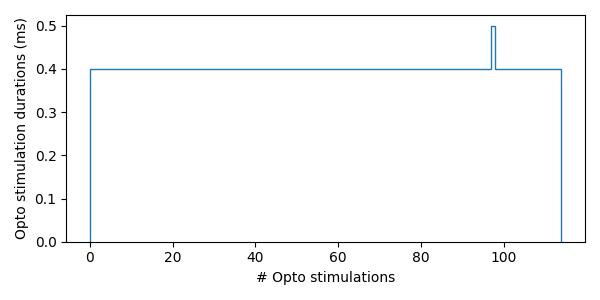

In [19]:
plt.close('all')
plt.figure(figsize=(6, 3))
plt.stairs(np.array(TTL_Opto_duration)*1000)
plt.xlabel('# Opto stimulations')
plt.ylabel('Opto stimulation durations (ms)')
plt.tight_layout()
plt.show()

### Get response of each brain region

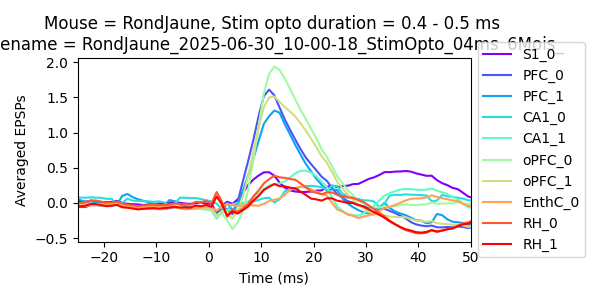

In [20]:
AllEPSPs=[]
for ttl in TTL_Opto:   
    idx = (np.abs(LFPtimestamps - ttl)).argmin() # find the closest LFP timestamps to the TTL
    AllEPSPs.append(combined[idx-round(0.5*samplerate):idx+round(0.5*samplerate), :]) #500 ms before and after TTL

plt.close()
plt.figure(figsize=(6, 3))
time_axis = np.linspace(-500, 500, np.shape(AllEPSPs)[1]) 
mEPSPs=np.mean(AllEPSPs, axis=0)
colors = cm.rainbow(np.linspace(0, 1, np.shape(mEPSPs)[1]))
for i in np.arange(0,np.shape(AllEPSPs)[2]):
    plt.plot(time_axis, mEPSPs[:,i], label=f'{RecordedArea[i]}', color=colors[i])
plt.xlabel("Time (ms)")
plt.ylabel("Averaged EPSPs")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncols=1)
plt.subplots_adjust(right=.5)
plt.xlim([-25, 50])
plt.title(f'Mouse = {mouse}, Stim opto duration = {np.unique(TTL_Opto_duration)[0]*1000} - {np.round(np.unique(TTL_Opto_duration)[-1]*1000,2)} ms \nfilename = {folder_base.parts[-6]}', fontsize=12) # Change to indicate where is located that LFP
plt.tight_layout()
plt.show()

### Get response for one brain region

Choose brain region

In [23]:
Selected_region='PFC_0' # to change
SelectedLFP=locals()[Selected_region]

Durée de stimulation: 0.4 ms
Nombre de stimulations: 114


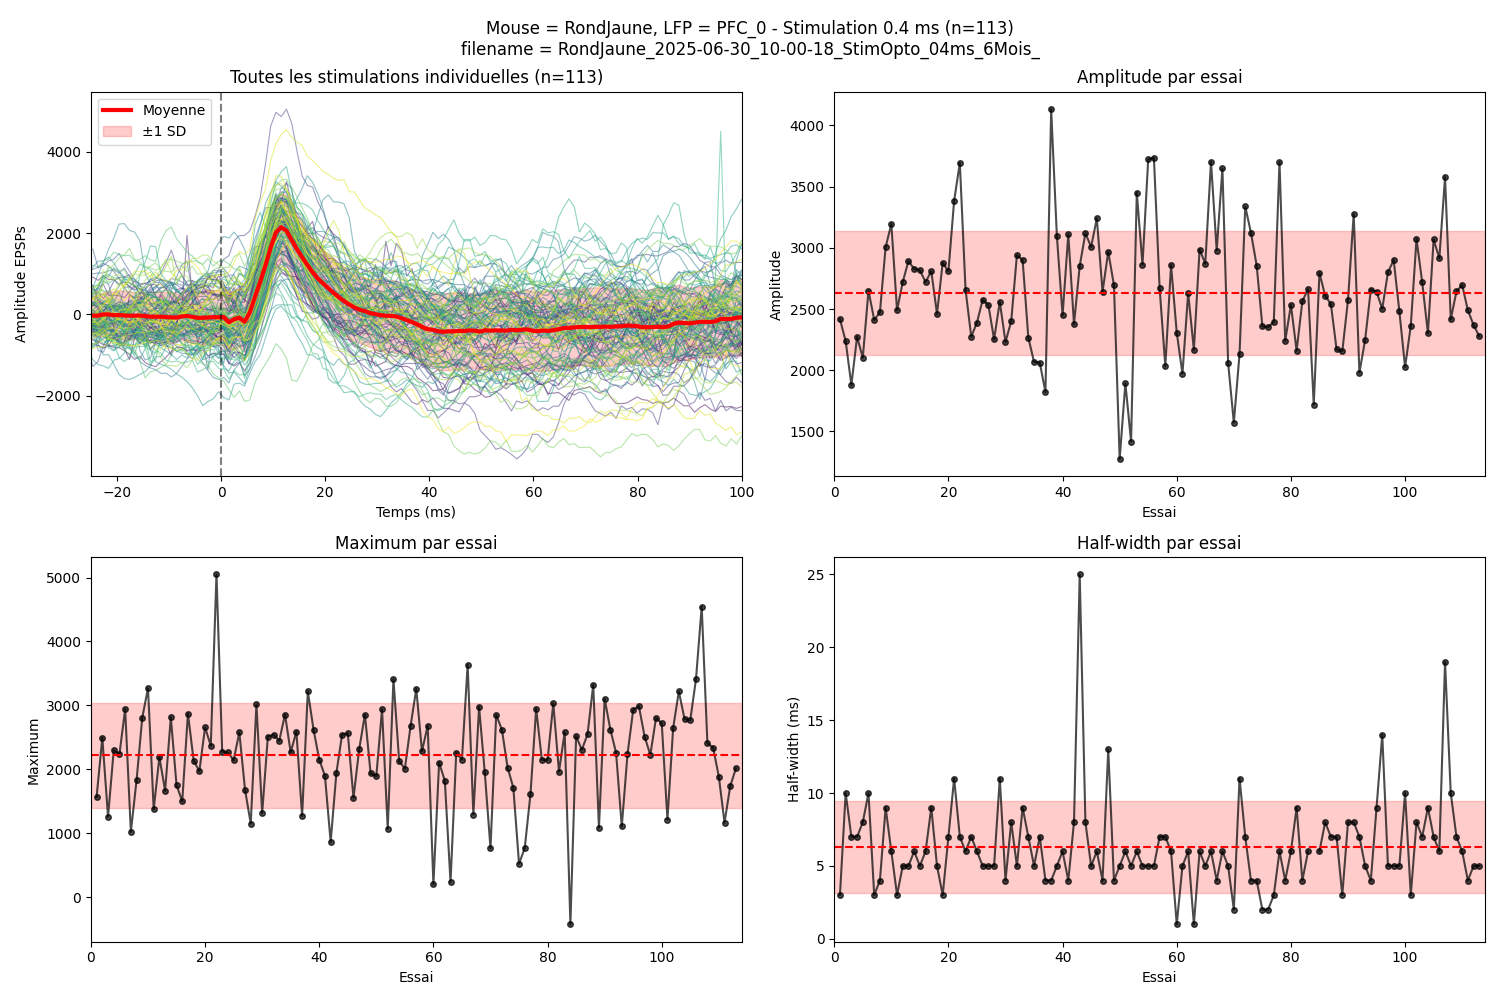


=== STATISTIQUES DESCRIPTIVES ===
Durée de stimulation: 0.4 ms
Nombre d'essais: 113

Amplitude:
  Moyenne ± SD: 2628.235 ± 507.611
  Médiane: 2608.593
  Min - Max: 1275.584 - 4133.465
  CV: 19.3%

Latence (ms):
  Moyenne ± SD: nan ± nan
  Médiane: nan
  Min - Max: nan - nan
  CV: nan%

Half-width (ms):
  Moyenne ± SD: 6.286 ± 3.158
  Médiane: 6.000
  Min - Max: 1.000 - 25.000
  CV: 50.2%
(n=112 valides sur 113)

Maximum:
  Moyenne ± SD: 2222.470 ± 820.109
  Médiane: 2267.163
  Min - Max: -422.497 - 5047.294
  CV: 36.9%

=== RÉSULTATS EXPORTABLES ===
DataFrame 'results_df' créé avec toutes les métriques par essai
Vous pouvez l'exporter avec : results_df.to_csv('resultats_stimulations.csv', index=False)


In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import integrate  # ✅ Import corrigé ici

# === PARAMÈTRES ===
halfdurEPSP = 0.1  # sec
analyseWindow = 0.025  # sec post-stimulation

stim_duration = np.unique(TTL_Opto_duration)[0] * 1000  # ms
nb_stims = len(TTL_Opto)

print(f"Durée de stimulation: {stim_duration} ms")
print(f"Nombre de stimulations: {nb_stims}")

# === EXTRACTION DES STIMULATIONS ===
AllStim_individual = []
for ttl in TTL_Opto:
    idx = (np.abs(LFPtimestamps - ttl)).argmin()
    stim_signal = SelectedLFP[idx - round(halfdurEPSP * samplerate): idx + round(halfdurEPSP * samplerate)]
    AllStim_individual.append(stim_signal)

AllStim_df = pd.DataFrame(AllStim_individual).T

# === CORRECTION DE BASELINE ===
baseline_window = slice(0, int(halfdurEPSP * samplerate))
corrected_columns = []
for col in AllStim_df.columns:
    baseline_mean = AllStim_df[col][baseline_window].mean()
    corrected_columns.append(AllStim_df[col] - baseline_mean)

AllStim_corrected = pd.concat(corrected_columns, axis=1)
AllStim_corrected.columns = AllStim_df.columns
AllStim_corrected = AllStim_corrected.copy()

# === CALCUL DES MÉTRIQUES ===
time_axis = np.linspace(-halfdurEPSP * 1000, halfdurEPSP * 1000, AllStim_corrected.shape[0])
post_stim_start = int(halfdurEPSP * samplerate)
post_stim_end = int((halfdurEPSP + analyseWindow) * samplerate)

Amplitude_individual = []
Max_individual = []
HalfMaxWidth_individual = []
Latency_individual = []

for col in AllStim_corrected.columns:
    post_stim_window = AllStim_corrected[col][post_stim_start:post_stim_end]
    amplitude = post_stim_window.max() - post_stim_window.min()
    maximum = post_stim_window.max()
    
    threshold = 0.1 * maximum
    try:
        latency_idx = post_stim_window[post_stim_window > threshold].index[0]
        latency_time = (latency_idx - post_stim_start) / samplerate * 1000  # ms
    except IndexError:
        latency_time = np.nan

    if maximum > 0:
        half_max = maximum / 2
        peak_idx = post_stim_window.idxmax()
        after_peak = AllStim_corrected[col][peak_idx:]
        try:
            below_half_idx = after_peak[after_peak < half_max].index[0]
            half_width = (below_half_idx - peak_idx) / samplerate * 1000  # ms
        except IndexError:
            half_width = np.nan
    else:
        half_width = np.nan

    Amplitude_individual.append(amplitude)
    Max_individual.append(maximum)
    HalfMaxWidth_individual.append(half_width)
    Latency_individual.append(latency_time)

# === SUPPRESSION OUTLIERS AMPLITUDE (≥ 4×SD) ===
amp_array = np.array(Amplitude_individual)
amp_mean = np.mean(amp_array)
amp_std = np.std(amp_array)
valid_indices = np.where(amp_array < amp_mean + 4 * amp_std)[0]

Amplitude_individual = [Amplitude_individual[i] for i in valid_indices]
Max_individual = [Max_individual[i] for i in valid_indices]
HalfMaxWidth_individual = [HalfMaxWidth_individual[i] for i in valid_indices]
Latency_individual = [Latency_individual[i] for i in valid_indices]
AllStim_corrected = AllStim_corrected.iloc[:, valid_indices]
nb_stims = len(valid_indices)

# === MOYENNE DES STIMULATIONS ===
mean_signal = AllStim_corrected.mean(axis=1)
std_signal = AllStim_corrected.std(axis=1)

# === VISUALISATION ===
plt.close()
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle(f'Mouse = {mouse}, LFP = {Selected_region} - Stimulation {stim_duration:.1f} ms (n={nb_stims})\nfilename = {folder_base.parts[-6]}', fontsize=12)

colors = plt.cm.viridis(np.linspace(0, 1, nb_stims))
for i, col in enumerate(AllStim_corrected.columns):
    axs[0, 0].plot(time_axis, AllStim_corrected[col], color=colors[i], alpha=0.5, linewidth=0.8)

axs[0, 0].plot(time_axis, mean_signal, color='red', linewidth=3, label='Moyenne')
axs[0, 0].fill_between(time_axis, mean_signal - std_signal, mean_signal + std_signal, color='red', alpha=0.2, label='±1 SD')
axs[0, 0].set(xlabel="Temps (ms)", ylabel="Amplitude EPSPs", xlim=(-25, 100))
axs[0, 0].legend()
axs[0, 0].set_title(f'Toutes les stimulations individuelles (n={nb_stims})')
axs[0, 0].axvline(x=0, color='black', linestyle='--', alpha=0.5)

# 2. Amplitude
stim_numbers = np.arange(1, nb_stims + 1)
axs[0, 1].plot(stim_numbers, Amplitude_individual, 'ko-', markersize=4, alpha=0.7)
axs[0, 1].axhline(np.mean(Amplitude_individual), color='red', linestyle='--')
axs[0, 1].fill_between([0, nb_stims+1], np.mean(Amplitude_individual) - np.std(Amplitude_individual), np.mean(Amplitude_individual) + np.std(Amplitude_individual), color='red', alpha=0.2)
axs[0, 1].set(xlabel="Essai", ylabel="Amplitude", xlim=[0, nb_stims + 1])
axs[0, 1].set_title("Amplitude par essai")

# 3. Maximum
axs[1, 0].plot(stim_numbers, Max_individual, 'ko-', markersize=4, alpha=0.7)
axs[1, 0].axhline(np.mean(Max_individual), color='red', linestyle='--')
axs[1, 0].fill_between([0, nb_stims+1], np.mean(Max_individual) - np.std(Max_individual), np.mean(Max_individual) + np.std(Max_individual), color='red', alpha=0.2)
axs[1, 0].set(xlabel="Essai", ylabel="Maximum", xlim=[0, nb_stims + 1])
axs[1, 0].set_title("Maximum par essai")

# 4. Half-width
valid_halfwidth = [hw for hw in HalfMaxWidth_individual if not np.isnan(hw)]
axs[1, 1].plot(stim_numbers, HalfMaxWidth_individual, 'ko-', markersize=4, alpha=0.7)
if valid_halfwidth:
    axs[1, 1].axhline(np.mean(valid_halfwidth), color='red', linestyle='--')
    axs[1, 1].fill_between([0, nb_stims+1], np.mean(valid_halfwidth) - np.std(valid_halfwidth), np.mean(valid_halfwidth) + np.std(valid_halfwidth), color='red', alpha=0.2)
axs[1, 1].set(xlabel="Essai", ylabel="Half-width (ms)", xlim=[0, nb_stims + 1])
axs[1, 1].set_title("Half-width par essai")

plt.tight_layout()
plt.show()

# === STATISTIQUES DESCRIPTIVES ===
print(f"\n=== STATISTIQUES DESCRIPTIVES ===")
print(f"Durée de stimulation: {stim_duration} ms")
print(f"Nombre d'essais: {nb_stims}")

def describe_metric(name, values):
    print(f"\n{name}:")
    print(f"  Moyenne ± SD: {np.mean(values):.3f} ± {np.std(values):.3f}")
    print(f"  Médiane: {np.median(values):.3f}")
    print(f"  Min - Max: {np.min(values):.3f} - {np.max(values):.3f}")
    print(f"  CV: {np.std(values)/np.mean(values)*100:.1f}%")

describe_metric("Amplitude", Amplitude_individual)
describe_metric("Latence (ms)", Latency_individual)
if valid_halfwidth:
    describe_metric("Half-width (ms)", valid_halfwidth)
    print(f"(n={len(valid_halfwidth)} valides sur {nb_stims})")
describe_metric("Maximum", Max_individual)




# === EXPORT DES RÉSULTATS ===
results_df = pd.DataFrame({
    'Essai': stim_numbers,
    'Amplitude': Amplitude_individual,
    'Latency_ms': Latency_individual,
    'HalfWidth_ms': HalfMaxWidth_individual,
    'Maximum': Max_individual
    
    
})

print(f"\n=== RÉSULTATS EXPORTABLES ===")
print("DataFrame 'results_df' créé avec toutes les métriques par essai")
print("Vous pouvez l'exporter avec : results_df.to_csv('resultats_stimulations.csv', index=False)")



In [200]:
print(f"Max post-stim = {post_stim_window.max()}, Min = {post_stim_window.min()}, Amplitude = {amplitude}")


Max post-stim = 2595.94, Min = 35.94, Amplitude = 2560.0


In [31]:
# Version simple et directe
nom_export = f'resultats_{folder_base.parts[-6]}_{Selected_region}.csv'
bureau = os.path.join(os.path.expanduser("~"), "Desktop", nom_export)
results_df.to_csv(bureau, index=False)
print(f"Fichier sauvegardé sur le bureau : {nom_export}")

Fichier sauvegardé sur le bureau : resultats_RondBleu_AHAD0142_2025-05-22_11-11-48_StimOpto_04ms_4mois__PFC_0.csv


### Flip omnetics headstage

Run the cell bellow if you believe omnetic headstage was reverted for this mouse during this session (if you run it twice it will go back to the initial configuration).

In [ ]:
rec_ch_list_ID = LFPs_df.columns-ID*32
rec_ch_list_mouse = [value for value in rec_ch_list_ID if 0 <= value <= 31]
i = np.argmax(rec_ch_list_ID>=0)
inverted_chs = np.concatenate([range(16,32,1), range(0,16,1)], axis=0)
LFPs_df_mouse=LFPs_df.iloc[:,i:i+len(rec_ch_list_mouse)]
flipped_ch=(inverted_chs[LFPs_df_mouse.columns-(ID*32)])+(ID*32)
LFPs_df.columns.values[i:i+len(rec_ch_list_mouse)] = flipped_ch
LFPs_df = LFPs_df.sort_index(axis=1)

# Reselect electrodes    
all_LFPcoordinates= all_LFPcoordinates.astype(str)
for region in all_LFPcoordinates.loc[mouse].index:
    locals()[f'{region}_0']=[]
    locals()[f'{region}_1']=[]
    locals()[f'{region}_0ch']=[]
    locals()[f'{region}_1ch']=[]

RecordedArea = []
ChoosenChannels = []
combined = []
if mouse:
    rec_ch_list_mouse = [value for value in rec_ch_list if 0+(ID*32) <= value <= 31+(ID*32)]
    for rec_ch in rec_ch_list_mouse:
        for idx, LFPcoord_str in enumerate(all_LFPcoordinates.loc[mouse]):
            region = all_LFPcoordinates.loc[mouse].index[idx]
            if LFPcoord_str != 'nan' and region != 'EMG':
                LFPcoord = LFPcoord_str.split('_')[:2] # only take into account the 2 first of electrode of that region 
                num_ch = np.where(str(rec_ch-(ID*32)) == np.array(LFPcoord))[0]
                if len(num_ch)>0:
                    region=all_LFPcoordinates.loc[mouse].index[idx]
                    LFP=locals()[f'{region}_0']
                    if len(LFP)>0:
                        LFP= np.array(LFPs_df[(rec_ch)])
                        locals()[f'{region}_1']=LFP
                        locals()[f'{region}_1ch']=rec_ch
                    else:
                        LFP= np.array(LFPs_df[(rec_ch)])
                        locals()[f'{region}_0']=LFP
                        locals()[f'{region}_0ch']=rec_ch
                    break
                continue
    
    for region in all_LFPcoordinates.loc[mouse].index:
        for n in range(0,2,1):
            LFP=locals()[f'{region}_{n}']
            LFP_ch=locals()[f'{region}_{n}ch']
            if len(LFP)>0:
                combined=zscore(LFP[:,np.newaxis]) if len(combined)==0 else np.append(combined, zscore(LFP[:,np.newaxis]), axis=1)
                RecordedArea.append(f'{region}_{n}') 
                ChoosenChannels.append(LFP_ch) 
else:
    print("/!\ No mouse name found in the path OR in the csv file '_LFP_coordinates_of_all_mice.csv'")
    mouse = '' # fill mouse name
    RecordedArea = ['PFC','S1'] 
    PFC_0 = LFPs_df[0]
    S1_1 = LFPs_df[1]
    combined = np.stack([zscore(PFC_0), zscore(S1_1)], axis=1)

print(mouse)
print(RecordedArea)
print(ChoosenChannels) 

Save if you're now sure that the omnetic headstage was reverted for this mouse during this recording

In [ ]:
if samplerate <= 1000:
    LFPs_df.to_pickle(f'{LFPfile.parent}/DataFrame_rawdataDS.pkl')
else: # best to downsample too
    new_sampling_rate = 1000 # Hz
    Nmber_points = int(np.shape(LFPs_df)[0] * new_sampling_rate / samplerate)
    LFPs_df_DS = pd.DataFrame(signal.resample(LFPs_df, Nmber_points, axis = 0), columns=LFPs_df.columns.values)
    LFPtimestampsDS = LFPtimestamps[::int(samplerate/new_sampling_rate)][:-1]
    samplerate = new_sampling_rate
    LFPs_df_DS.to_pickle(f'{LFPfile.parent}/DataFrame_rawdataDS.pkl')
    np.save(f'{file_pathTS.parent}/timeStampsDS.npy', LFPtimestampsDS)
    LFPs_df = LFPs_df_DS
    LFPtimestamps = LFPtimestampsDS